In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "engineering-placements-prediction"

In [2]:
library(caret)
library(C50)
library(randomForest)
library(corrplot)
library(ROCR)
library(gmodels)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


corrplot 0.88 loaded



In [3]:
placement_data <- read.csv('../input/engineering-placements-prediction/collegePlace.csv')
head(placement_data)
str(placement_data)

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
1,22,Male,Electronics And Communication,1,8,1,1,1
2,21,Female,Computer Science,0,7,1,1,1
3,22,Female,Information Technology,1,6,0,0,1
4,21,Male,Information Technology,0,8,0,1,1
5,22,Male,Mechanical,0,8,1,0,1
6,22,Male,Electronics And Communication,0,6,0,0,0


'data.frame':	2966 obs. of  8 variables:
 $ Age              : int  22 21 22 21 22 22 21 21 21 21 ...
 $ Gender           : chr  "Male" "Female" "Female" "Male" ...
 $ Stream           : chr  "Electronics And Communication" "Computer Science" "Information Technology" "Information Technology" ...
 $ Internships      : int  1 0 1 0 0 0 0 1 2 1 ...
 $ CGPA             : int  8 7 6 8 8 6 7 7 6 6 ...
 $ Hostel           : int  1 1 0 0 1 0 0 0 0 1 ...
 $ HistoryOfBacklogs: int  1 1 0 1 0 0 1 0 0 0 ...
 $ PlacedOrNot      : int  1 1 1 1 1 0 0 0 1 0 ...


## EXPLORATORY DATA ANALYSIS

Age,PlacedOrNot
<int>,<dbl>
19,0.5897436
20,0.5306667
21,0.5691882
22,0.5079702
23,0.4358974
24,0.7938931
25,0.7586207
26,0.7400000
28,1.0000000


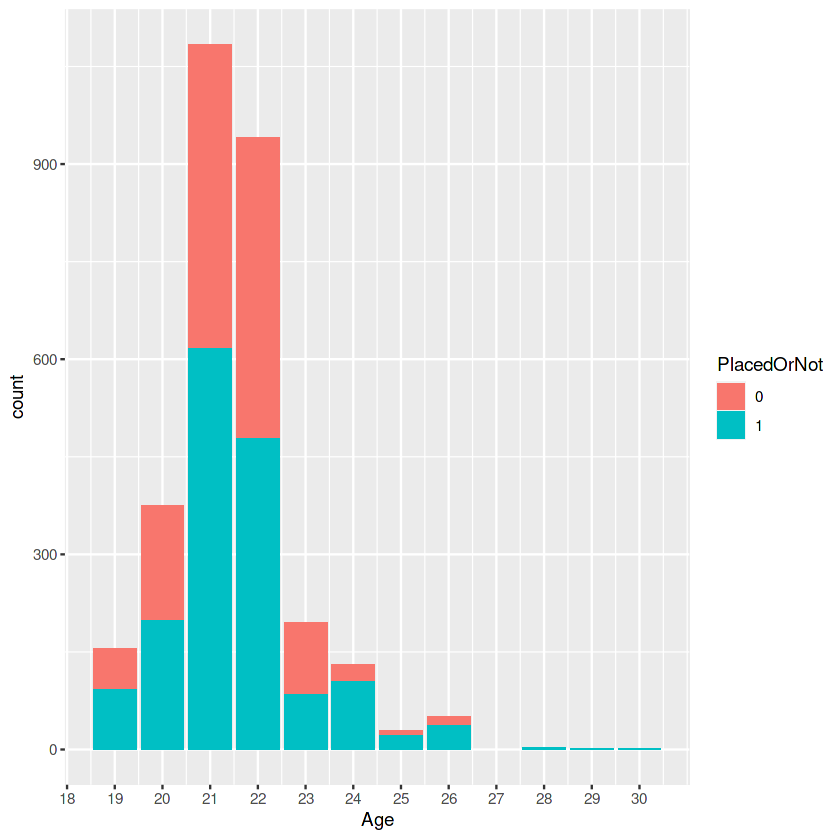

In [4]:
aggregate(PlacedOrNot~Age, data=placement_data, FUN=mean)
placement_data %>% 
        ggplot(aes(Age, fill=factor(PlacedOrNot))) + 
            geom_bar() + 
            scale_x_continuous(breaks=seq(18,30, by=1)) +
            labs(fill="PlacedOrNot")

In [5]:
aggregate(PlacedOrNot~Gender, data=placement_data, FUN=mean)

Gender,PlacedOrNot
<chr>,<dbl>
Female,0.5600815
Male,0.5511111


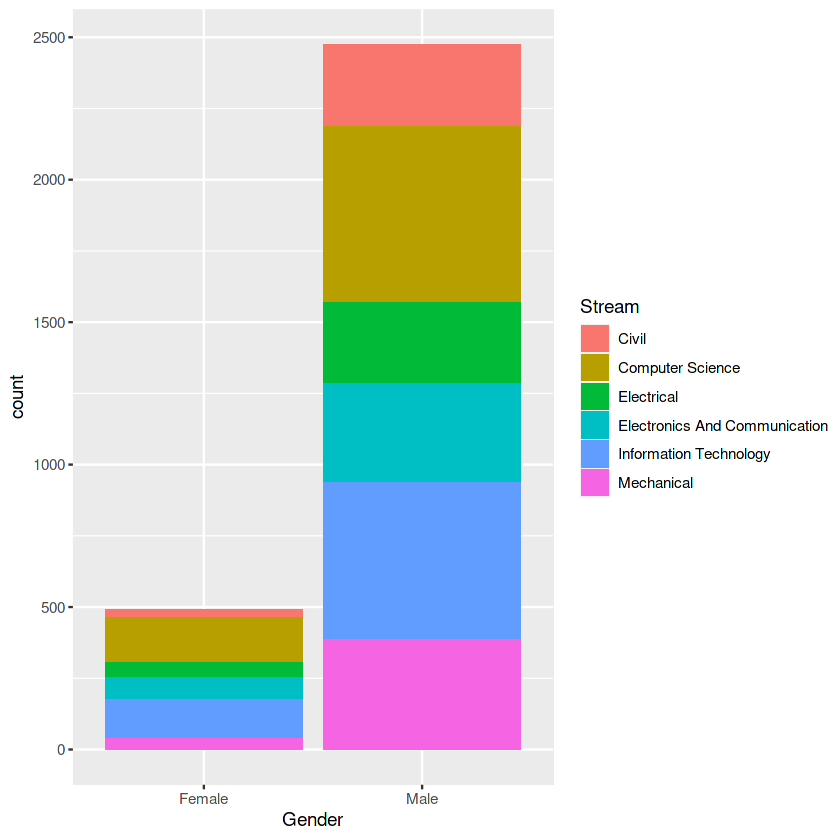

In [6]:
placement_data %>% 
    ggplot(aes(Gender, fill=Stream)) +
        geom_bar()                   

Stream,PlacedOrNot
<chr>,<dbl>
Civil,0.4605678
Computer Science,0.5824742
Electrical,0.5419162
Electronics And Communication,0.5919811
Information Technology,0.5918958
Mechanical,0.4716981


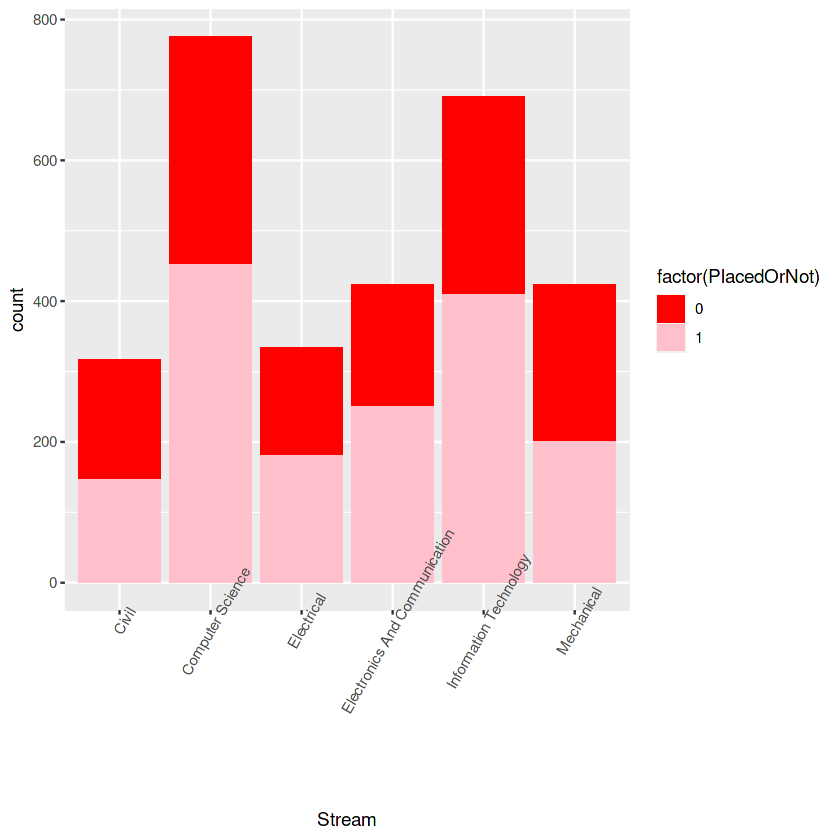

In [7]:
aggregate(PlacedOrNot~Stream, data=placement_data, FUN=mean)
placement_data %>% 
        ggplot(aes(Stream)) + 
            geom_bar(aes(fill=factor(PlacedOrNot))) +
            theme(axis.text.x=element_text(angle=60)) +
            scale_fill_manual(values=c("red", "pink"))

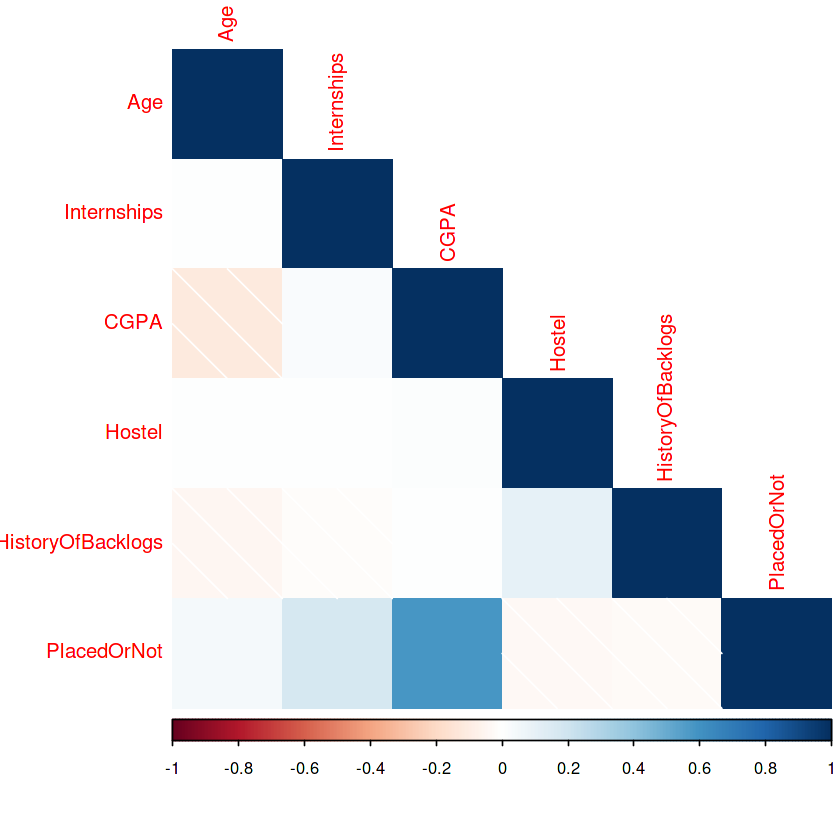

In [8]:
num <- function(x){
    x <- as.numeric(x)
}
p <- as.data.frame(lapply(placement_data[,-c(2,3)], FUN = num))
corrplot(cor(p), method="shade", type="lower")

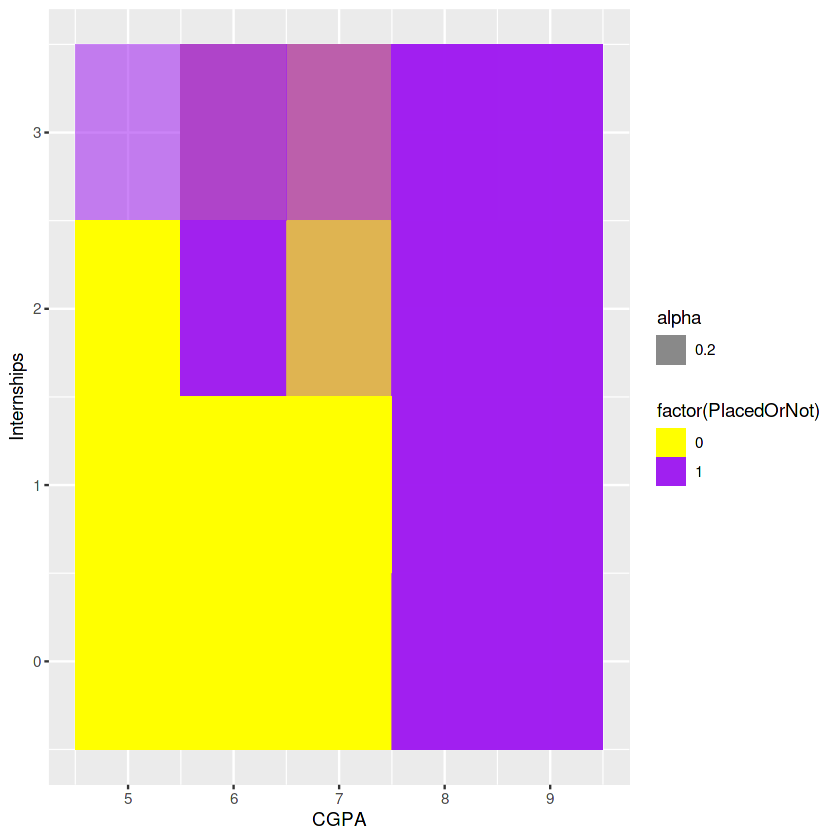

In [9]:
placement_data %>% 
        ggplot(aes(CGPA, Internships, fill=factor(PlacedOrNot), alpha=0.2)) + 
            geom_tile() + 
            scale_fill_manual(values=c("yellow", "purple"))

Hostel,HistoryOfBacklogs,PlacedOrNot
<int>,<int>,<dbl>
0,0,0.5678670
1,0,0.5279188
0,1,0.5454545
1,1,0.5024155


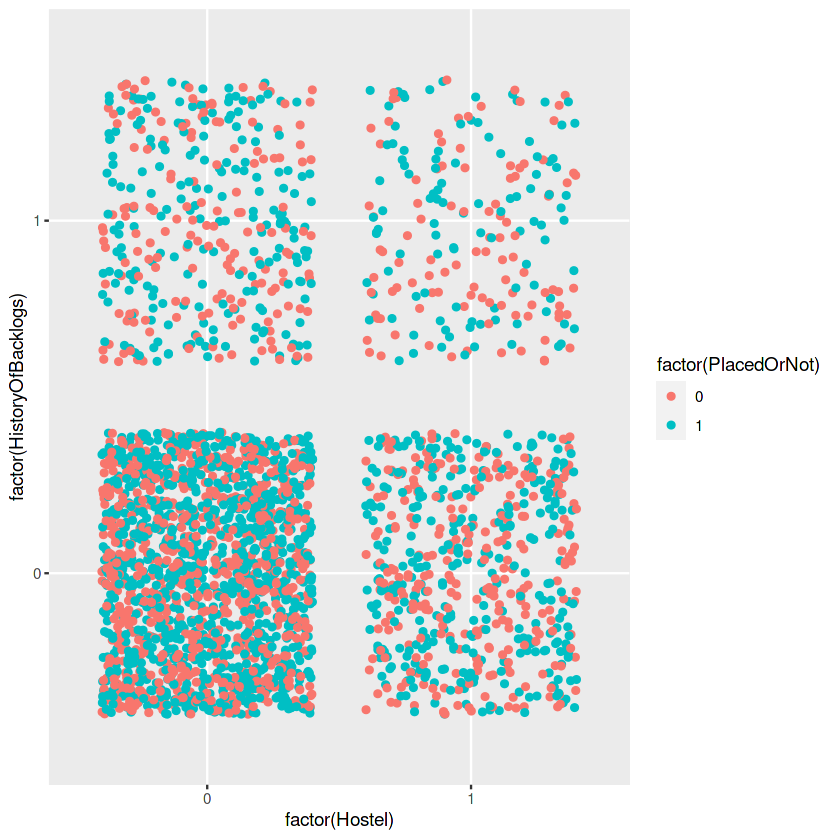

In [10]:
aggregate(PlacedOrNot~Hostel+HistoryOfBacklogs, data=placement_data, FUN=mean)
placement_data %>% 
        ggplot(aes(factor(Hostel), factor(HistoryOfBacklogs), color=factor(PlacedOrNot))) + 
            geom_jitter()

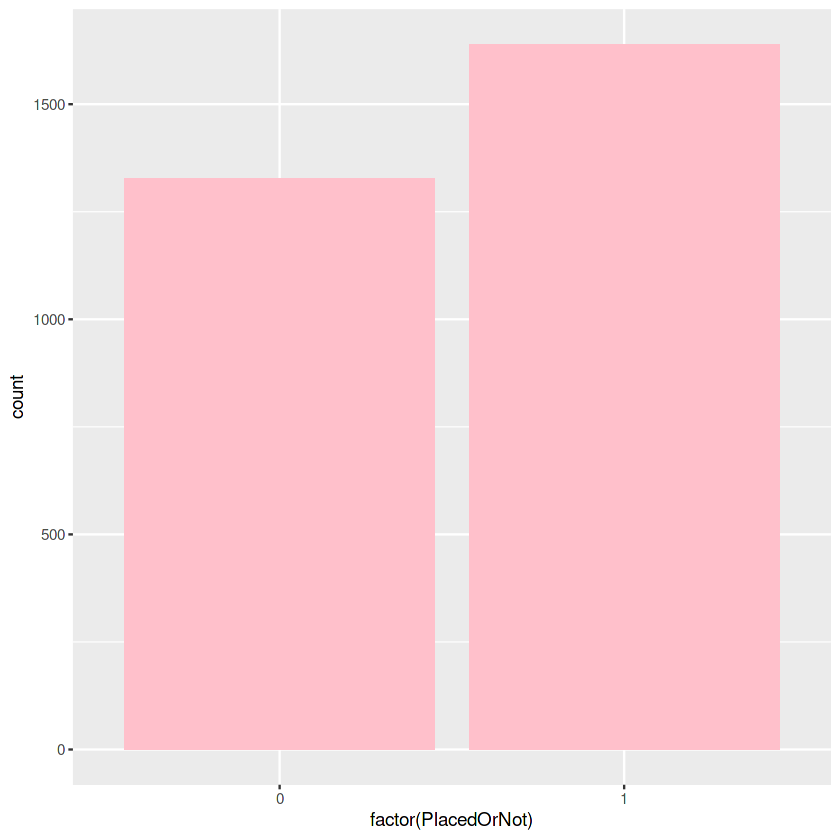

In [11]:
placement_data %>% 
        ggplot(aes(factor(PlacedOrNot))) + 
            geom_bar(fill="pink")

In [12]:
prop.table(table(placement_data$PlacedOrNot))


        0         1 
0.4474039 0.5525961 

### CONCLUSIONS:
* Engineering students are most probably aged between 21-22.
* Age group between 28-30 years is more likely to be placed.
* Male and female have approximately same chances of getting placed and have more or less likely same choices of stream, that is, Computer Science and Electronics and Communication Engineering.
* There is very less proportion of female data may be because female are less likely to take up engineering.
* Electronics and communication engineering students are more often placed followed by Information technology and Computer science.
* Higher CGPA or more internships are required to land up a job.
* Students living in hostel have less backlogs but students not living in hostel have more tendency to get placed even after backlogs.

## MODELLING

#### Decision tree

In [13]:
placement_data$PlacedOrNot <- factor(placement_data$PlacedOrNot, levels=c("0","1"), labels=c("no","yes"))

In [14]:
set.seed(123)
train_in <- createDataPartition(placement_data$PlacedOrNot, p=0.70, list=FALSE)
train_data <- placement_data[train_in,]
test_data <- placement_data[-train_in,]

In [15]:
model1 <- C5.0(x=train_data[-8], train_data$PlacedOrNot)
model1


Call:
C5.0.default(x = train_data[-8], y = train_data$PlacedOrNot)

Classification Tree
Number of samples: 2077 
Number of predictors: 7 

Tree size: 14 

Non-standard options: attempt to group attributes


In [16]:
predict1 <- predict(model1, test_data[-8])

In [17]:
CrossTable(test_data$PlacedOrNot, predict1,
 prop.chisq = FALSE, prop.c = FALSE, prop.r = FALSE,
 dnn = c('actual', 'predicted'))


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  889 

 
             | predicted 
      actual |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
          no |       393 |         5 |       398 | 
             |     0.442 |     0.006 |           | 
-------------|-----------|-----------|-----------|
         yes |       112 |       379 |       491 | 
             |     0.126 |     0.426 |           | 
-------------|-----------|-----------|-----------|
Column Total |       505 |       384 |       889 | 
-------------|-----------|-----------|-----------|

 


In [18]:
confusionMatrix(test_data$PlacedOrNot, predict1, positive="yes")

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  393   5
       yes 112 379
                                          
               Accuracy : 0.8684          
                 95% CI : (0.8444, 0.8899)
    No Information Rate : 0.5681          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7405          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9870          
            Specificity : 0.7782          
         Pos Pred Value : 0.7719          
         Neg Pred Value : 0.9874          
             Prevalence : 0.4319          
         Detection Rate : 0.4263          
   Detection Prevalence : 0.5523          
      Balanced Accuracy : 0.8826          
                                          
       'Positive' Class : yes             
                              

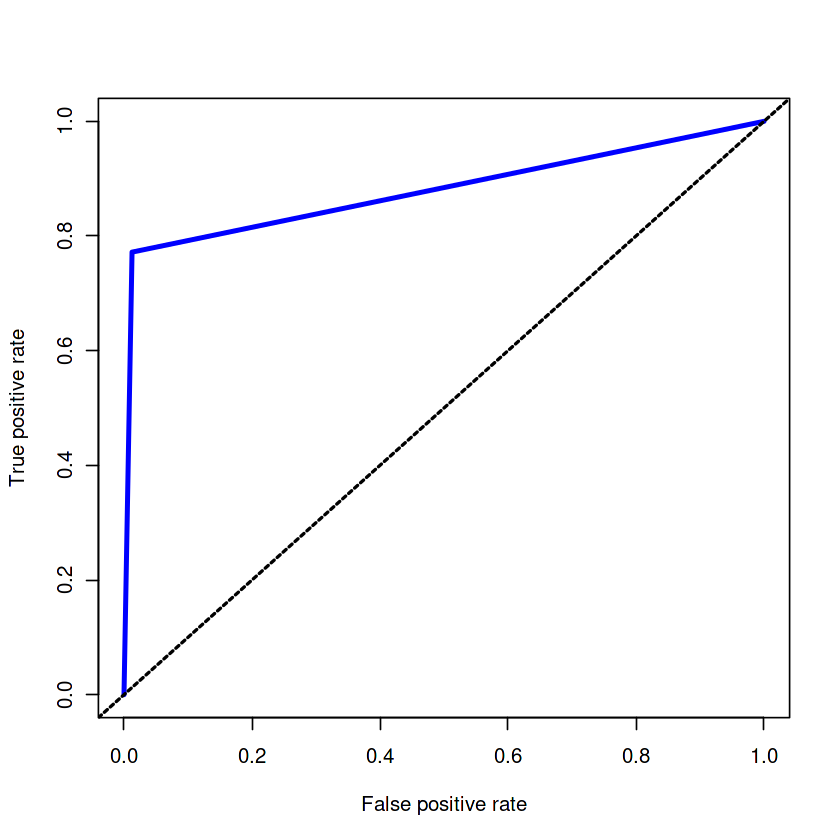

In [19]:
pred <- prediction(predictions=as.data.frame(c(predict1)), labels=test_data$PlacedOrNot)
perf <- performance(pred, measure = "tpr", x.measure="fpr")
plot(perf, lwd="3", col="blue")
 abline(a = 0, b = 1, lwd = 2, lty = 2)

#### Tuning the parameters

In [20]:
ctrl2 <- trainControl(method="cv", number = 10, selectionFunction="best")
model2 <- train(PlacedOrNot~., data=train_data, method="C5.0", trcontrol=ctrl2)
model2

Warning message:
“'trials' should be <= 9 for this object. Predictions generated using 9 trials”
Warning message:
“'trials' should be <= 9 for this object. Predictions generated using 9 trials”
Warning message:
“'trials' should be <= 7 for this object. Predictions generated using 7 trials”
Warning message:
“'trials' should be <= 9 for this object. Predictions generated using 9 trials”
Warning message:
“'trials' should be <= 9 for this object. Predictions generated using 9 trials”


C5.0 

2077 samples
   7 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2077, 2077, 2077, 2077, 2077, 2077, ... 
Resampling results across tuning parameters:

  model  winnow  trials  Accuracy   Kappa    
  rules  FALSE    1      0.8848599  0.7700795
  rules  FALSE   10      0.8723363  0.7431016
  rules  FALSE   20      0.8774194  0.7541316
  rules   TRUE    1      0.8860885  0.7724958
  rules   TRUE   10      0.8713451  0.7410522
  rules   TRUE   20      0.8777825  0.7548332
  tree   FALSE    1      0.8825897  0.7655632
  tree   FALSE   10      0.8808979  0.7617196
  tree   FALSE   20      0.8822204  0.7645296
  tree    TRUE    1      0.8835644  0.7674999
  tree    TRUE   10      0.8813033  0.7626561
  tree    TRUE   20      0.8825752  0.7653149

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were trials = 1, model = rules and winnow
 = TRUE.

In [21]:
predict2 <- predict(model2, test_data[-8])

In [22]:
confusionMatrix(test_data$PlacedOrNot, predict2, positive = "yes")

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  387  11
       yes 110 381
                                          
               Accuracy : 0.8639          
                 95% CI : (0.8396, 0.8858)
    No Information Rate : 0.5591          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7311          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9719          
            Specificity : 0.7787          
         Pos Pred Value : 0.7760          
         Neg Pred Value : 0.9724          
             Prevalence : 0.4409          
         Detection Rate : 0.4286          
   Detection Prevalence : 0.5523          
      Balanced Accuracy : 0.8753          
                                          
       'Positive' Class : yes             
                              

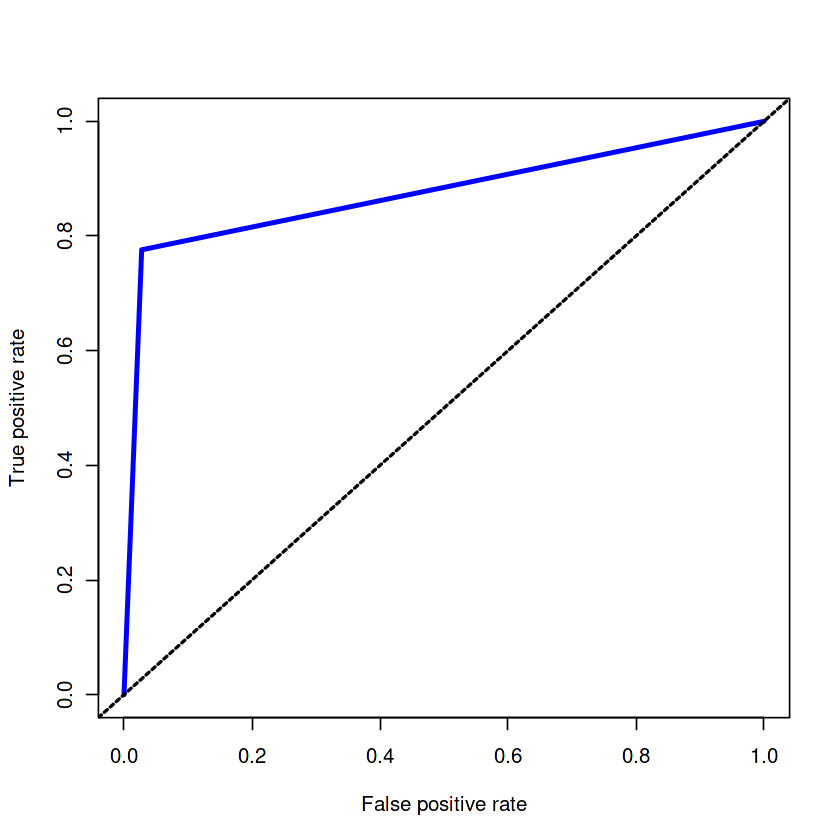

In [23]:
pred <- prediction(predictions=as.data.frame(c(predict2)), labels=test_data$PlacedOrNot)
perf <- performance(pred, measure = "tpr", x.measure="fpr")
plot(perf, lwd="3", col="blue")
 abline(a = 0, b = 1, lwd = 2, lty = 2)

#### Random Forests

In [24]:
model3 <- randomForest(PlacedOrNot~., data=train_data, mtry=sqrt(7))
model3


Call:
 randomForest(formula = PlacedOrNot ~ ., data = train_data, mtry = sqrt(7)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 11.22%
Confusion matrix:
     no yes class.error
no  878  51  0.05489774
yes 182 966  0.15853659

In [25]:
predict3 <- predict(model3, test_data[-8])

In [26]:
confusionMatrix(test_data$PlacedOrNot, predict3, positive="yes")

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  377  21
       yes  92 399
                                          
               Accuracy : 0.8729          
                 95% CI : (0.8492, 0.8941)
    No Information Rate : 0.5276          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7472          
                                          
 Mcnemar's Test P-Value : 4.547e-11       
                                          
            Sensitivity : 0.9500          
            Specificity : 0.8038          
         Pos Pred Value : 0.8126          
         Neg Pred Value : 0.9472          
             Prevalence : 0.4724          
         Detection Rate : 0.4488          
   Detection Prevalence : 0.5523          
      Balanced Accuracy : 0.8769          
                                          
       'Positive' Class : yes             
                              

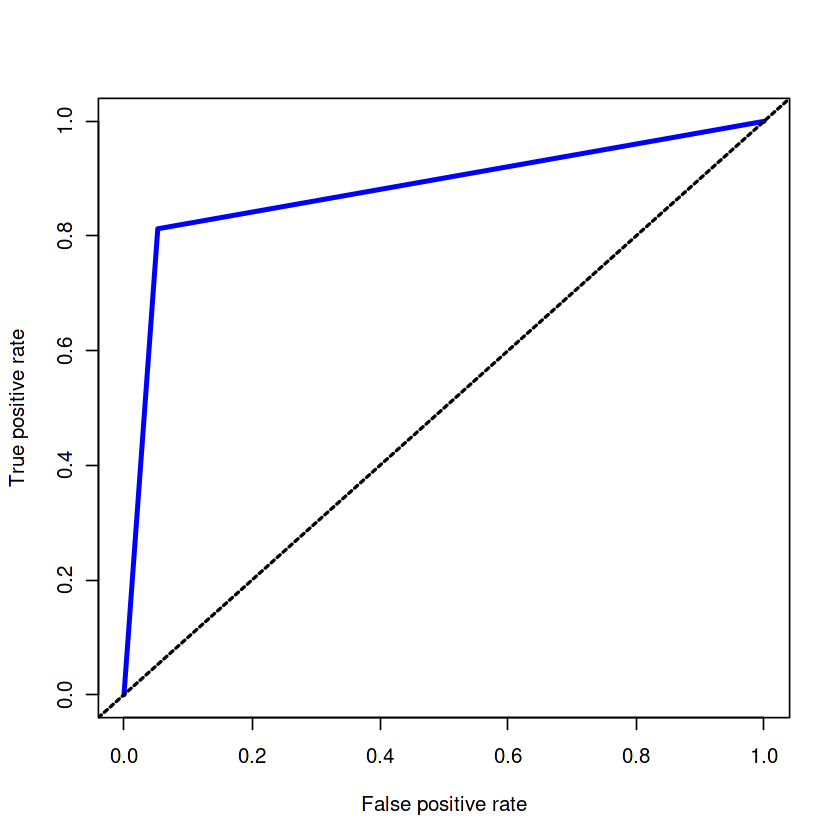

In [27]:
pred <- prediction(predictions=as.data.frame(c(predict3)), labels=test_data$PlacedOrNot)
perf <- performance(pred, measure = "tpr", x.measure="fpr")
plot(perf, lwd="3", col="blue")
 abline(a = 0, b = 1, lwd = 2, lty = 2)

#### Tuning the Parameters

In [28]:
ctrl4 <- trainControl(method="repeatedcv", number=10, repeats=10)
grid4 <- expand.grid(.mtry=c(2,4,8,16))
model4 <- train(PlacedOrNot~., data=train_data, method="rf", trControl=ctrl4,tuneGrid=grid4)
model4

Random Forest 

2077 samples
   7 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 1869, 1870, 1870, 1870, 1869, 1869, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8774718  0.7556445
   4    0.8871513  0.7748720
   8    0.8857996  0.7715762
  16    0.8848859  0.7698060

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.

In [29]:
predict4 <- predict(model4, test_data[-8])

In [30]:
confusionMatrix(test_data$PlacedOrNot, predict4, positive="yes")

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  378  20
       yes  99 392
                                         
               Accuracy : 0.8661         
                 95% CI : (0.842, 0.8878)
    No Information Rate : 0.5366         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.7343         
                                         
 Mcnemar's Test P-Value : 8.662e-13      
                                         
            Sensitivity : 0.9515         
            Specificity : 0.7925         
         Pos Pred Value : 0.7984         
         Neg Pred Value : 0.9497         
             Prevalence : 0.4634         
         Detection Rate : 0.4409         
   Detection Prevalence : 0.5523         
      Balanced Accuracy : 0.8720         
                                         
       'Positive' Class : yes            
                                         

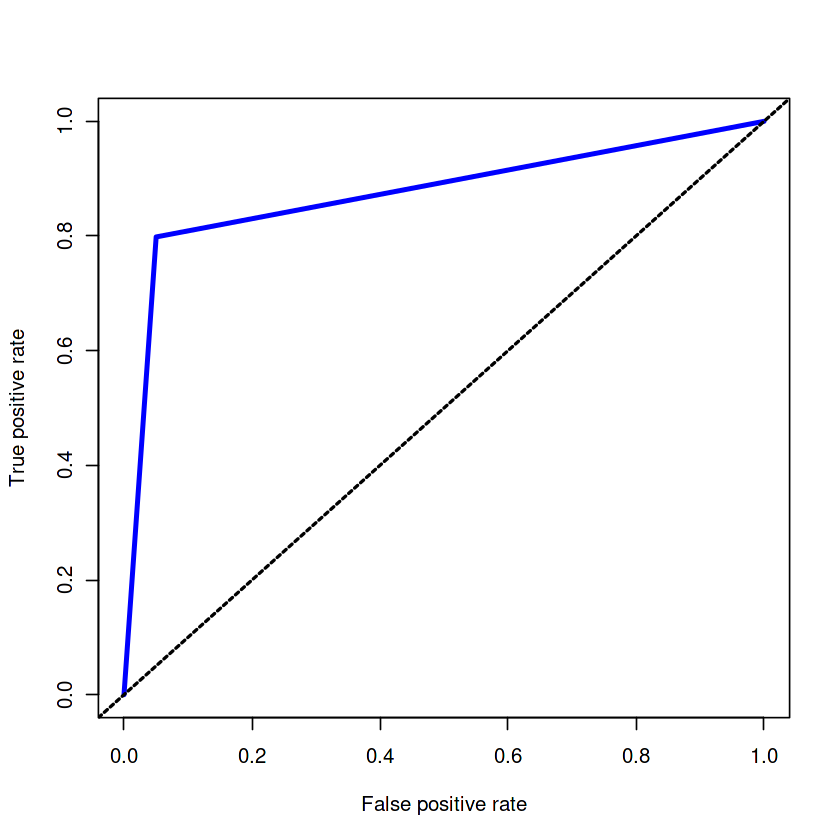

In [31]:
pred <- prediction(predictions=as.data.frame(c(predict4)), labels=test_data$PlacedOrNot)
perf <- performance(pred, measure = "tpr", x.measure="fpr")
plot(perf, lwd="3", col="blue")
 abline(a = 0, b = 1, lwd = 2, lty = 2)

This shows that Random Forest works best here with 87.29% accuracy on testing data